In [122]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import json  
import mpl_toolkits
import sys
import os
import pickle
import glob
import re
import itertools
from PIL import Image, ImageDraw
import time


import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc





import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import callbacks
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD


%matplotlib inline



from skimage.feature import hog
from skimage import data, color, exposure
from sklearn import cross_validation

## Notes on Keras
Conv1D - a time-based convolution- each step is a 1D sequence. Will not work well on imahes at all
Conv2D - image analysis generally, can handle RGB
Conv3D - computationally expensive

strides - can specify width vs height


In [26]:
x_vect = pickle.load(open('x_vect.pkl','rb'))
y_vect = pickle.load(open('y_vect.pkl','rb'))
x_reshaped = pickle.load(open('image_data.pkl', 'rb'))
y_reshaped = pickle.load(open('image_tag.pkl', 'rb'))

In [49]:
xtrain, xtest, ytrain, ytest = train_test_split(np.asarray(x_reshaped), y_reshaped, test_size=0.2, random_state = 1234, stratify = y_vect, shuffle = True)

## Run byrachonok keras model

In [71]:
f = open(r'shipsnet_data/shipsnet.json')
dataset = json.load(f)
f.close()

In [72]:
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')

In [73]:
input_data.shape

(2800, 19200)

In [74]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
X[0].shape

(3, 80, 80)

In [75]:
# get one chanel
pic = X[0]

rad_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectum = pic[2]

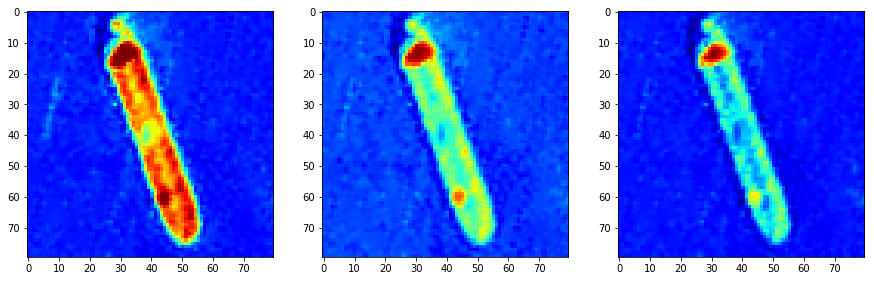

In [76]:
plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

# show each channel
plt.subplot(1, 3, 1)
plt.imshow(rad_spectrum)

plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)

plt.subplot(1, 3, 3)
plt.imshow(blue_spectum)
    
plt.show()

In [80]:
output_data

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [82]:
np.bincount(output_data)

array([2100,  700])

### Prep the data

In [84]:
# output encoding
y = np_utils.to_categorical(output_data, 2)

In [85]:
# shuffle all indexes
indexes = np.arange(2800)
np.random.shuffle(indexes)

In [86]:
X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]

In [87]:
# normalization
X_train = X_train / 255

### train the network

In [89]:
np.random.seed(42)

In [91]:
# network design
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [92]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training
model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

Train on 2240 samples, validate on 560 samples
Epoch 1/18
 - 19s - loss: 0.4523 - acc: 0.8067 - val_loss: 0.3160 - val_acc: 0.8893
Epoch 2/18
 - 18s - loss: 0.2565 - acc: 0.8915 - val_loss: 0.2279 - val_acc: 0.9179
Epoch 3/18
 - 18s - loss: 0.2137 - acc: 0.9156 - val_loss: 0.1959 - val_acc: 0.9304
Epoch 4/18
 - 18s - loss: 0.1893 - acc: 0.9254 - val_loss: 0.1432 - val_acc: 0.9500
Epoch 5/18
 - 18s - loss: 0.1595 - acc: 0.9388 - val_loss: 0.1229 - val_acc: 0.9536
Epoch 6/18
 - 18s - loss: 0.1640 - acc: 0.9366 - val_loss: 0.1444 - val_acc: 0.9411
Epoch 7/18
 - 18s - loss: 0.1278 - acc: 0.9562 - val_loss: 0.1042 - val_acc: 0.9661
Epoch 8/18
 - 18s - loss: 0.1205 - acc: 0.9567 - val_loss: 0.0806 - val_acc: 0.9804
Epoch 9/18
 - 18s - loss: 0.1230 - acc: 0.9571 - val_loss: 0.0824 - val_acc: 0.9643
Epoch 10/18
 - 18s - loss: 0.1127 - acc: 0.9616 - val_loss: 0.1025 - val_acc: 0.9643
Epoch 11/18
 - 18s - loss: 0.1176 - acc: 0.9549 - val_loss: 0.0847 - val_acc: 0.9661
Epoch 12/18
 - 18s - loss: 

### Apply to image

In [94]:
image = Image.open('shipsnet_data/scenes/sfbay_1.png')
pix = image.load()

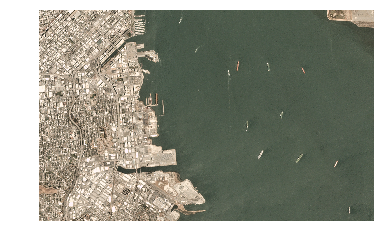

In [102]:
plt.imshow(image)
plt.axis('off');

In [99]:
n_spectrum = 3
width = image.size[0]
height = image.size[1]

In [103]:
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

In [112]:
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)

In [113]:
picture_tensor.shape

(1777, 2825, 3)

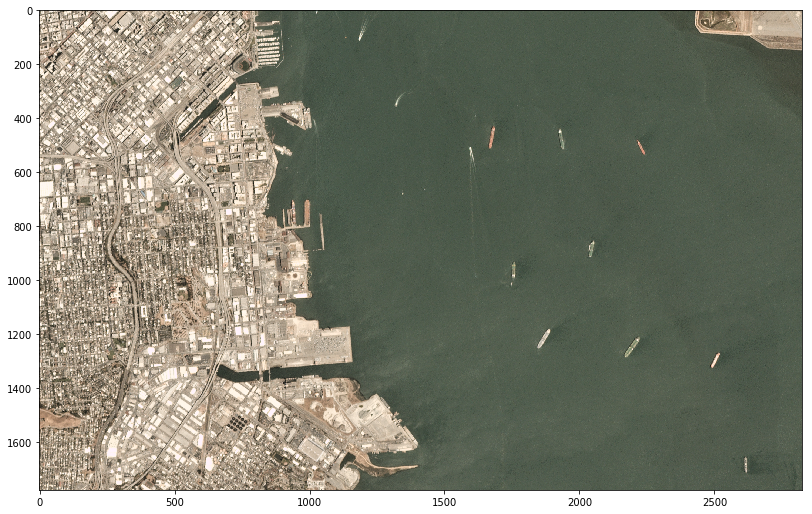

In [114]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

In [115]:
picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor.shape

(3, 1777, 2825)

### Search the image

In [118]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [119]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [120]:
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

X:1890 Y:430  [[0.08511 0.91489]]


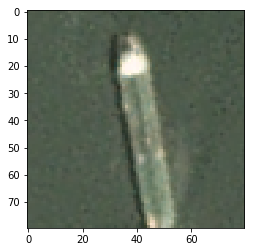

X:2190 Y:470  [[7.0033464e-05 9.9992990e-01]]


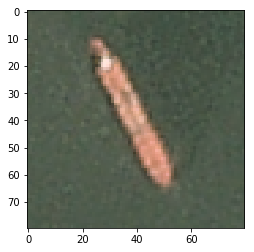

X:1560 Y:490  [[0.00465206 0.9953479 ]]


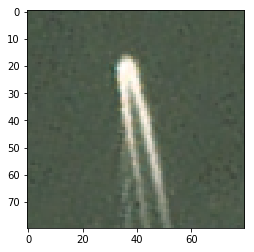

X:2460 Y:1260  [[0.07885149 0.9211485 ]]


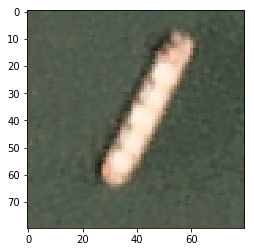

X:1310 Y:1650  [[0.08834359 0.9116564 ]]


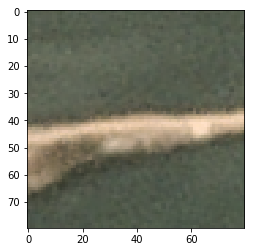

X:2740 Y:1690  

In [123]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [125]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [126]:
#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1777, 2825, 3)

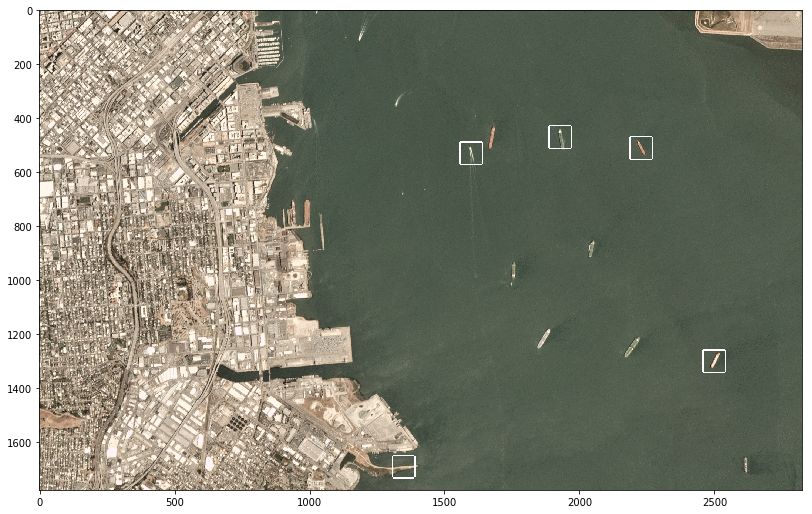

In [127]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()